In [42]:
import pandas as pd

# Load the provided CSV files
center_results = pd.read_csv('center_results_all_models.csv')
random_results = pd.read_csv('random_results_all_models.csv')


In [43]:
# Add a column to distinguish between center and random masks
center_results['Mask_Type'] = 'center'
random_results['Mask_Type'] = 'random'

# Combine the results for easier comparison
all_results = pd.concat([center_results, random_results], ignore_index=True)


In [44]:
all_results

,Model,Time (s),Memory (MB),PSNR,MAE,MSE,LPIPS,Image_Name,Image_Size,Mask_Size,Mask_Type
0,pruned_model_1.pth,0.5846,1749.61,20.2135,115.4832,619.0539,0.1015,image10,1000x750,100x100,center
1,pruned_model_1.pth,0.1781,1749.61,23.1836,114.2053,312.4083,NaN,image10,1000x750,12x12,center
2,pruned_model_1.pth,0.1795,1749.61,18.7105,121.3018,875.0407,0.2444,image10,1000x750,150x150,center
3,pruned_model_1.pth,0.1795,1749.61,19.1892,138.5490,783.7247,0.4493,image10,1000x750,200x200,center
4,pruned_model_1.pth,0.1775,1749.61,22.4615,84.4915,368.9174,NaN,image10,1000x750,25x25,center
...,...,...,...,...,...,...,...,...,...,...,...
119995,pruned_model_7.pth,0.0300,270.21,13.8970,121.6530,2650.8075,0.5259,image9,500x375,200x200,random
119996,pruned_model_7.pth,0.0300,270.21,21.9889,92.7230,411.3296,NaN,image9,500x375,25x25,random
119997,pruned_model_7.pth,0.0300,270.21,17.3524,141.6199,1196.2909,0.1523,image9,500x375,50x50,random
119998,pruned_model_7.pth,0.0340,270.21,21.2522,105.3067,487.3733,NaN,image9,500x375,6x6,random


In [45]:
def extract_pruning_percentage(model_name):
    try:
        if 'pruned_model_' in model_name:
            # Extract the percentage from the model name
            return int(model_name.split('_')[-1].split('.')[0])
        else:
            return 0  # Assuming the original model is named differently
    except Exception as e:
        print(f"Error parsing model name {model_name}: {e}")
        return None  # Or handle it as needed

# Add the pruning percentage column
center_results['Pruning_Percentage'] = center_results['Model'].apply(extract_pruning_percentage)
random_results['Pruning_Percentage'] = random_results['Model'].apply(extract_pruning_percentage)

# Remove any rows where Pruning_Percentage could not be determined
center_results = center_results.dropna(subset=['Pruning_Percentage'])
random_results = random_results.dropna(subset=['Pruning_Percentage'])

# Function to calculate mean and standard deviation for each group
def summarize_results(df, group_by_cols):
    summary = df.groupby(group_by_cols).agg(
        PSNR_mean=('PSNR', 'mean'), PSNR_std=('PSNR', 'std'),
        MSE_mean=('MSE', 'mean'), MSE_std=('MSE', 'std'),
        MAE_mean=('MAE', 'mean'), MAE_std=('MAE', 'std'),
        LPIPS_mean=('LPIPS', 'mean'), LPIPS_std=('LPIPS', 'std')
    ).reset_index()
    return summary

# Summarize results by model and image size, separately for center and random masks
center_summary = summarize_results(center_results, ['Pruning_Percentage', 'Image_Size'])
random_summary = summarize_results(random_results, ['Pruning_Percentage', 'Image_Size'])


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot metrics
def plot_metric(summary, metric, ylabel, title, save_as_pdf=False, pdf_path=None):
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=summary, x='Pruning_Percentage', y=f'{metric}_mean', hue='Image_Size', marker='o', errorbar=None)
    plt.fill_between(summary['Pruning_Percentage'], 
                     summary[f'{metric}_mean'] - summary[f'{metric}_std'], 
                     summary[f'{metric}_mean'] + summary[f'{metric}_std'], 
                     alpha=0.2)
    plt.title(title)
    plt.xlabel('Pruning Percentage')
    plt.ylabel(ylabel)
    plt.legend(title='Image Size')
    plt.grid(True)
    
    # Save the plot as PDF if requested
    if save_as_pdf and pdf_path is not None:
        plt.savefig(pdf_path, format='pdf')
    
    plt.show()

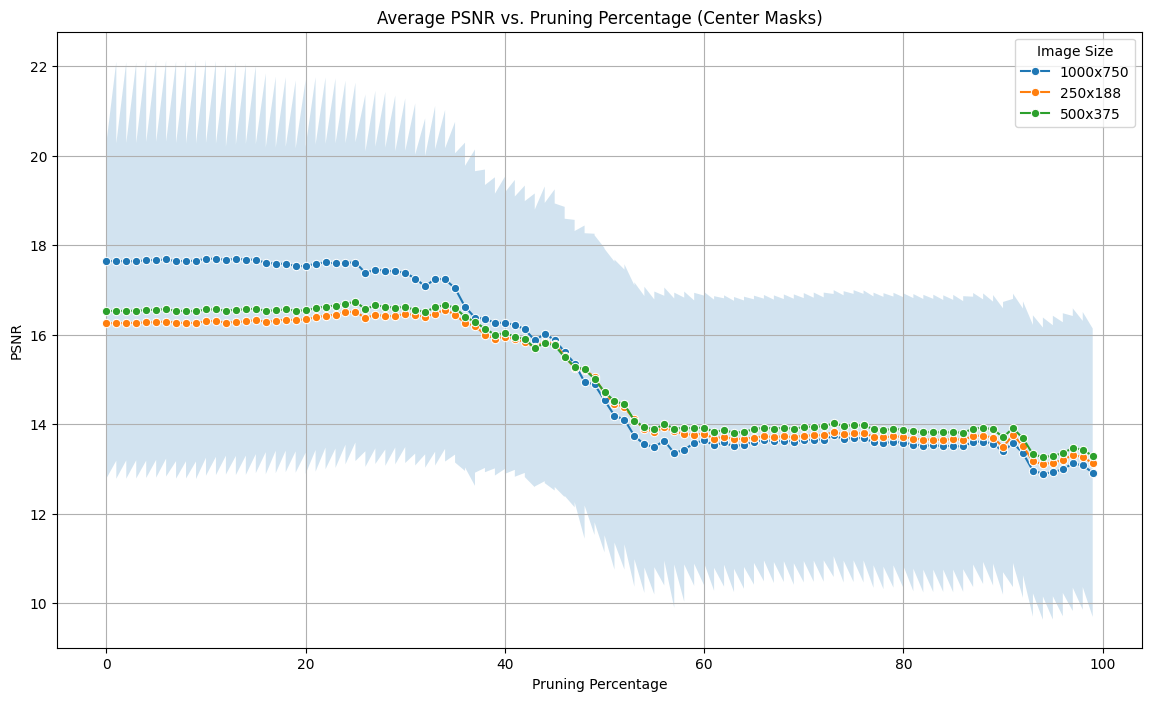

In [47]:
# Plot PSNR for center masks and save as PDF
plot_metric(center_summary, 'PSNR', 'PSNR', 'Average PSNR vs. Pruning Percentage (Center Masks)', save_as_pdf=True, pdf_path='center_psnr.pdf')



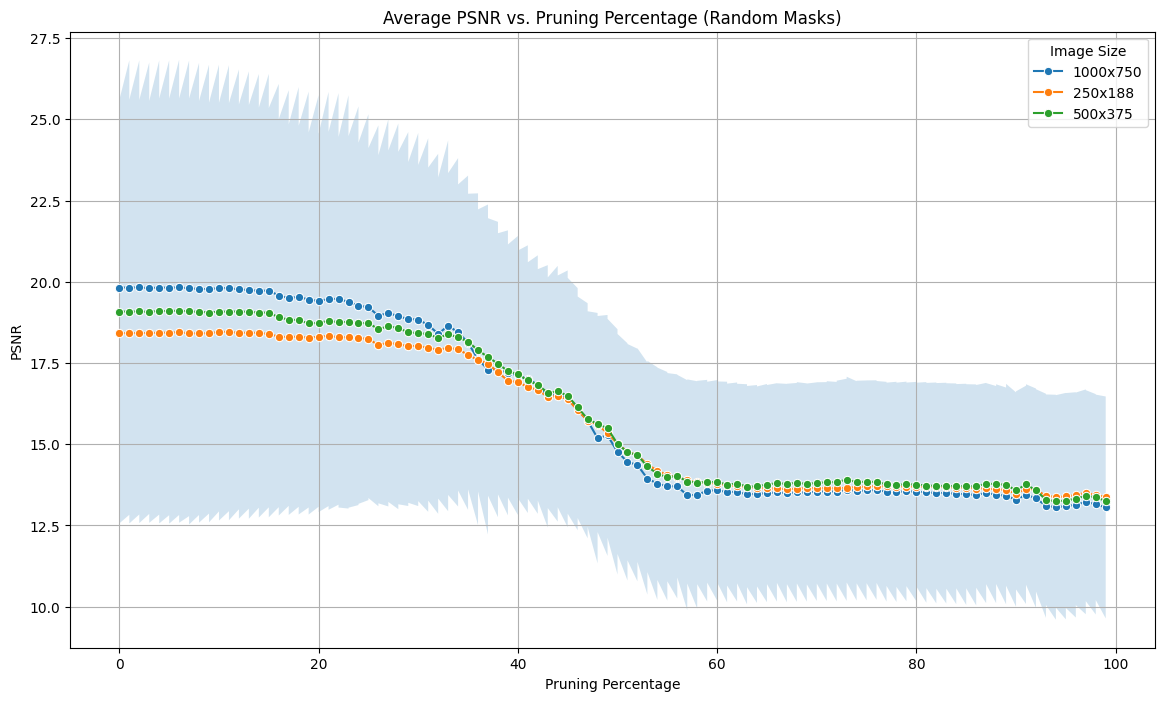

In [48]:
# Plot PSNR for random masks and save as PDF
plot_metric(random_summary, 'PSNR', 'PSNR', 'Average PSNR vs. Pruning Percentage (Random Masks)', save_as_pdf=True, pdf_path='random_psnr.pdf')



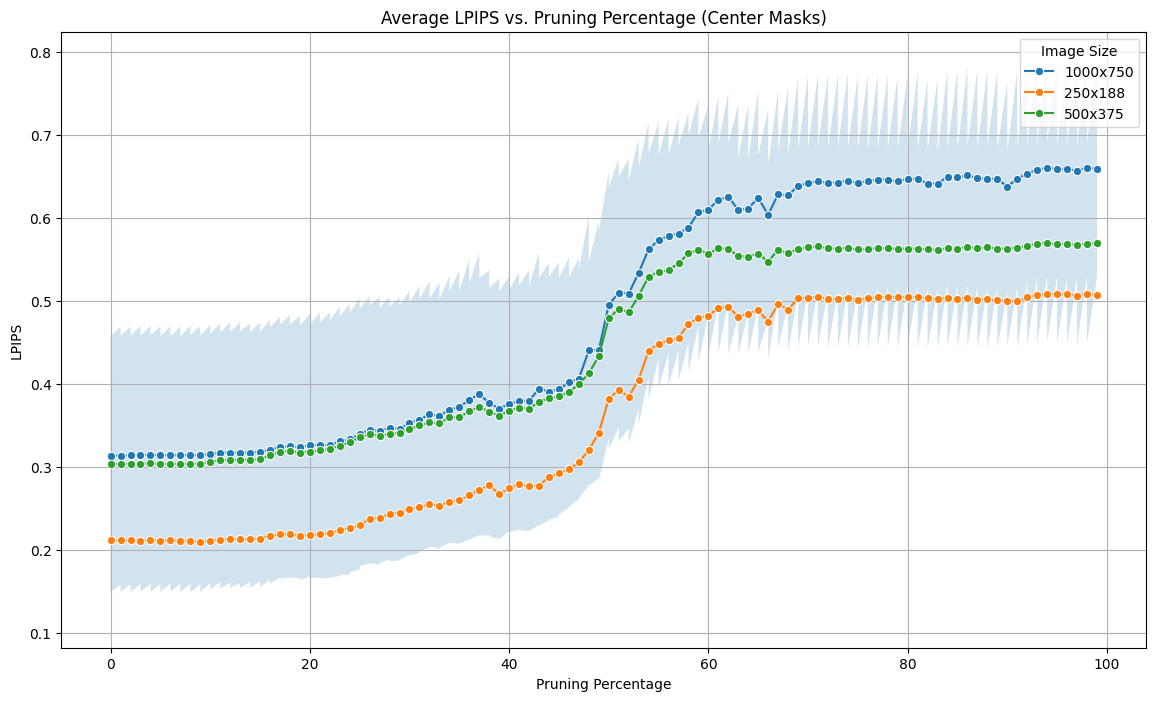

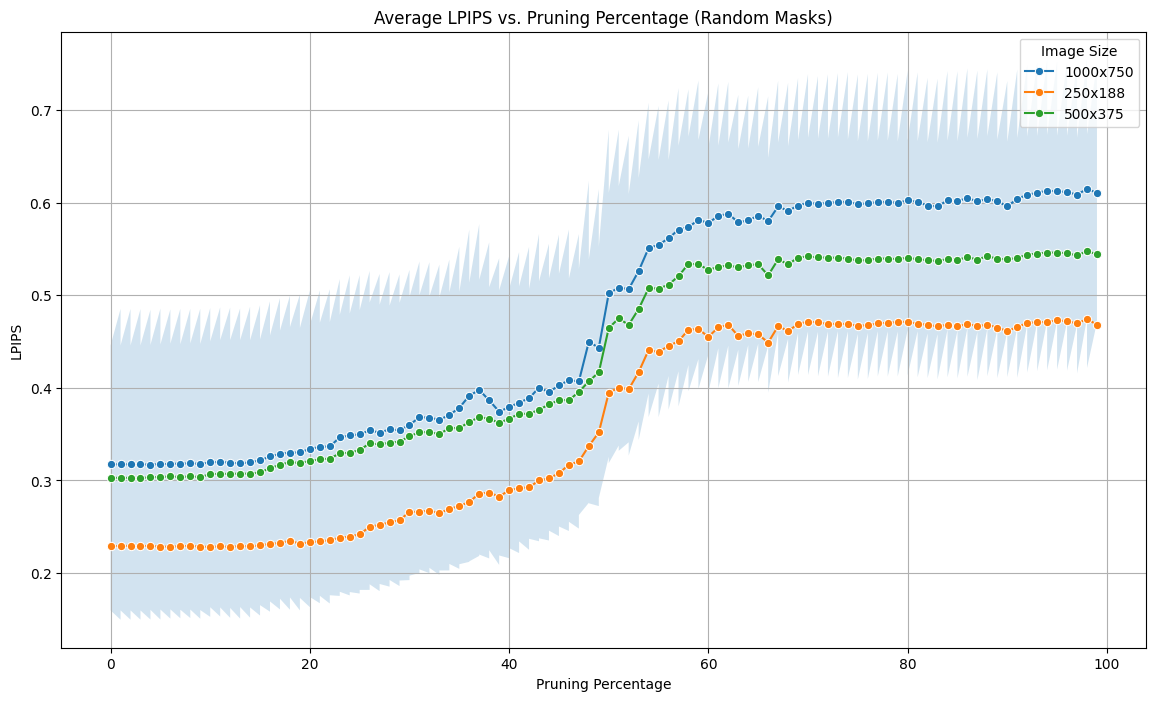

In [49]:
# Repeat for LPIPS and MAE/MSE
plot_metric(center_summary, 'LPIPS', 'LPIPS', 'Average LPIPS vs. Pruning Percentage (Center Masks)', save_as_pdf=True, pdf_path='center_lpips.pdf')
plot_metric(random_summary, 'LPIPS', 'LPIPS', 'Average LPIPS vs. Pruning Percentage (Random Masks)', save_as_pdf=True, pdf_path='random_lpips.pdf')



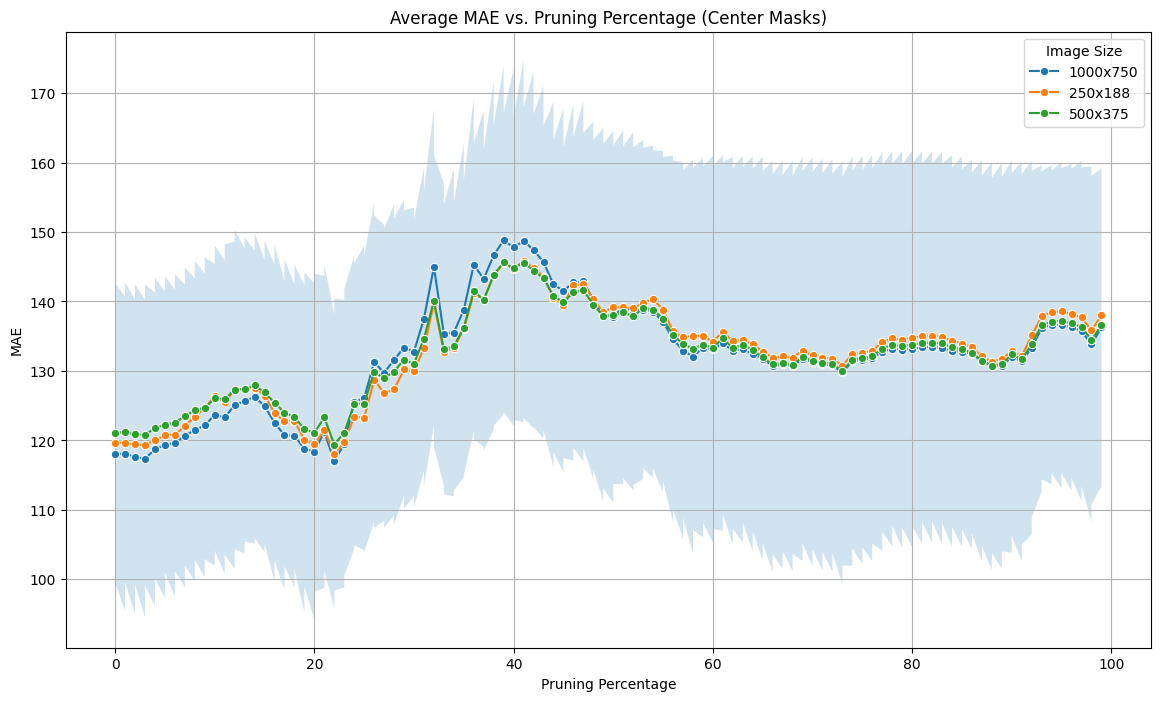

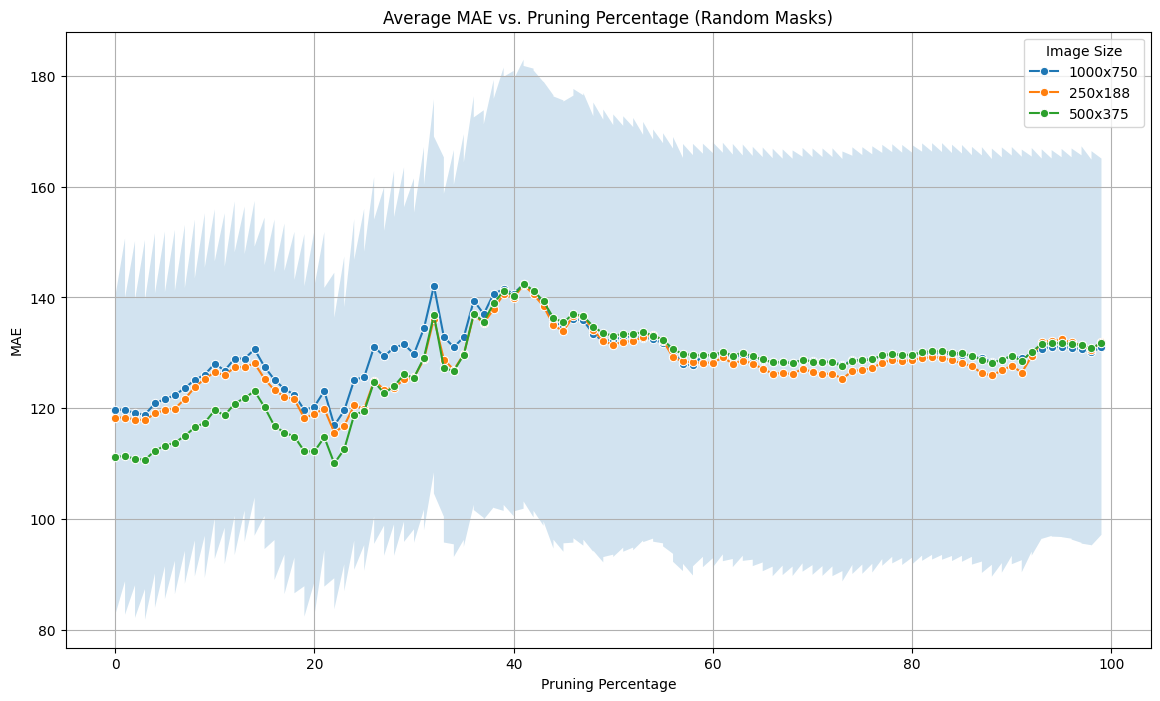

In [50]:
plot_metric(center_summary, 'MAE', 'MAE', 'Average MAE vs. Pruning Percentage (Center Masks)', save_as_pdf=True, pdf_path='center_mae.pdf')
plot_metric(random_summary, 'MAE', 'MAE', 'Average MAE vs. Pruning Percentage (Random Masks)', save_as_pdf=True, pdf_path='random_mae.pdf')

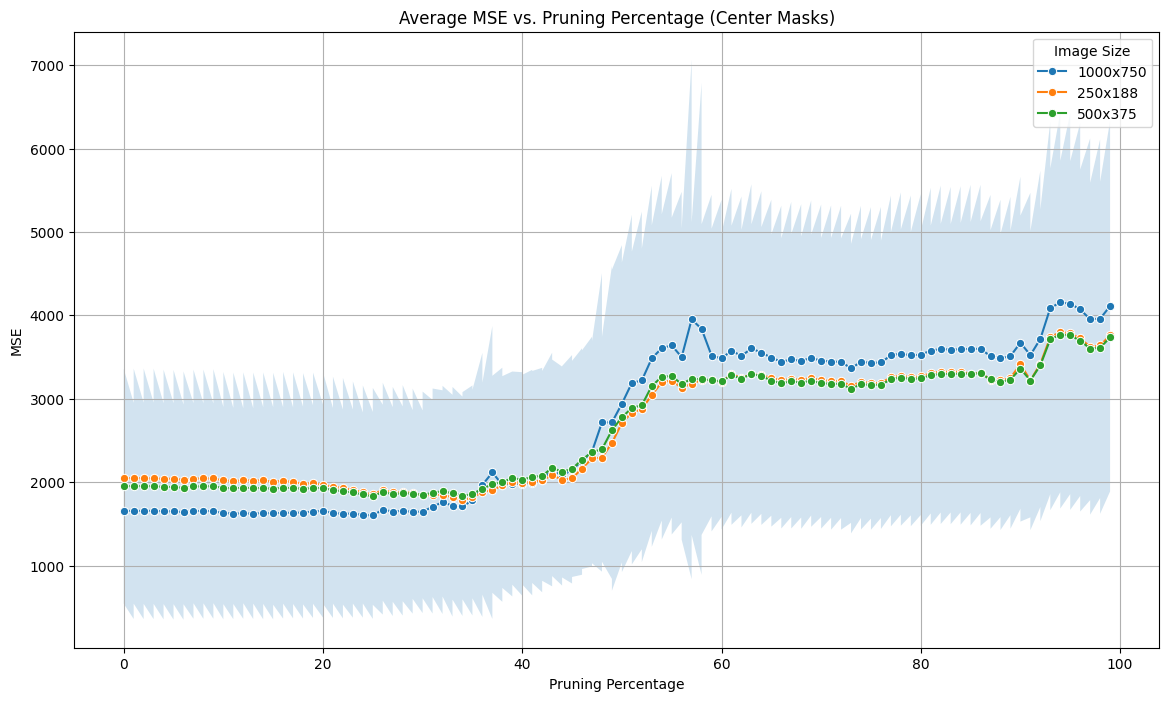

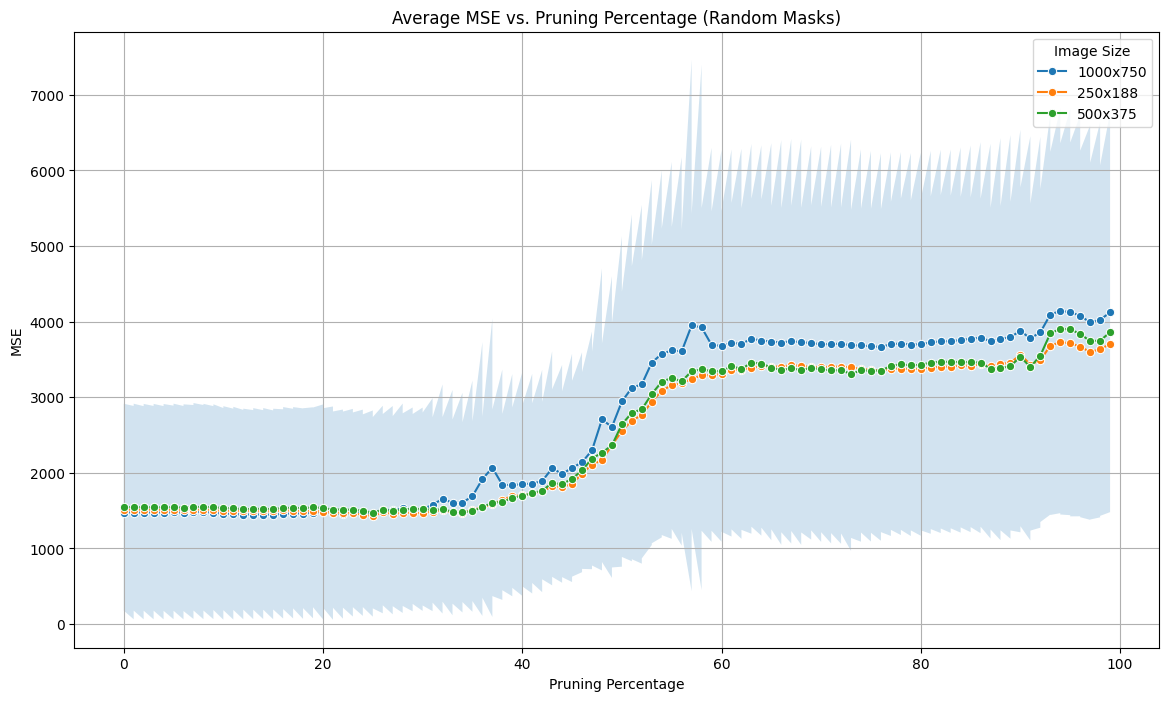

In [51]:
plot_metric(center_summary, 'MSE', 'MSE', 'Average MSE vs. Pruning Percentage (Center Masks)', save_as_pdf=True, pdf_path='center_mse.pdf')
plot_metric(random_summary, 'MSE', 'MSE', 'Average MSE vs. Pruning Percentage (Random Masks)', save_as_pdf=True, pdf_path='random_mse.pdf')

In [52]:
import pandas as pd
import scipy.stats as stats

# Assuming 'center_summary' and 'random_summary' dataframes from previous analysis

# Perform t-test for PSNR
psnr_ttest = stats.ttest_ind(center_summary['PSNR_mean'], random_summary['PSNR_mean'])
print("PSNR t-test p-value:", psnr_ttest.pvalue)

# Perform t-test for LPIPS
lpips_ttest = stats.ttest_ind(center_summary['LPIPS_mean'], random_summary['LPIPS_mean'])
print("LPIPS t-test p-value:", lpips_ttest.pvalue)


PSNR t-test p-value: 6.924543905932482e-07
LPIPS t-test p-value: 0.2889937116366737


In [53]:
# Combine the results for easier comparison
all_results = pd.concat([center_results, random_results], ignore_index=True)

# Function to extract pruning percentage
def extract_pruning_percentage(model_name):
    try:
        if 'pruned_model_' in model_name:
            # Extract the percentage from the model name
            return int(model_name.split('_')[-1].split('.')[0])
        else:
            return 0  # Assuming the original model is named differently
    except Exception as e:
        print(f"Error parsing model name {model_name}: {e}")
        return None  # Or handle it as needed

# Add the pruning percentage column
all_results['Pruning_Percentage'] = all_results['Model'].apply(extract_pruning_percentage)

# Remove any rows where Pruning_Percentage could not be determined
all_results = all_results.dropna(subset=['Pruning_Percentage'])

# Filter to include only up to 25% pruning
filtered_results = all_results[all_results['Pruning_Percentage'] <= 25]

In [54]:
# Summarize results by model, image size, and mask size, separately for center and random masks
center_summary = filtered_results[filtered_results['Mask_Type'] == 'center'].groupby(['Image_Size', 'Mask_Size']).agg(
    PSNR_mean=('PSNR', 'mean'),
    PSNR_std=('PSNR', 'std')
).reset_index()

random_summary = filtered_results[filtered_results['Mask_Type'] == 'random'].groupby(['Image_Size', 'Mask_Size']).agg(
    PSNR_mean=('PSNR', 'mean'),
    PSNR_std=('PSNR', 'std')
).reset_index()

# Summarize LPIPS combined
combined_lpips_summary = filtered_results.groupby(['Image_Size', 'Mask_Size']).agg(
    LPIPS_mean=('LPIPS', 'mean'),
    LPIPS_std=('LPIPS', 'std')
).reset_index()

In [55]:
center_summary, random_summary, combined_lpips_summary


(   Image_Size Mask_Size  PSNR_mean  PSNR_std
 0    1000x750   100x100  17.527108  3.164966
 1    1000x750     12x12  20.630098  4.788756
 2    1000x750   150x150  16.122770  2.662585
 3    1000x750   200x200  14.883618  2.256596
 4    1000x750     25x25  20.506437  4.580161
 5    1000x750   300x300  14.468882  1.839227
 6    1000x750   400x400  13.634365  1.653767
 7    1000x750     50x50  18.879053  3.356939
 8    1000x750       6x6  21.887872  4.464657
 9    1000x750     75x75  17.792880  3.261566
 10    250x188   100x100  13.803502  2.216508
 11    250x188     12x12  18.442039  2.985175
 12    250x188     25x25  17.212222  2.940907
 13    250x188     50x50  14.940526  2.686013
 14    250x188       6x6  19.005830  3.450474
 15    250x188     75x75  14.508576  2.132740
 16    500x375   100x100  14.887689  2.503057
 17    500x375     12x12  18.710447  3.462614
 18    500x375   150x150  14.510219  2.041982
 19    500x375   200x200  13.810053  2.032027
 20    500x375     25x25  17.63457

In [56]:
center_mae_summary = filtered_results[filtered_results['Mask_Type'] == 'center'].groupby(['Image_Size', 'Mask_Size']).agg(
    MAE_mean=('MAE', 'mean'),
    MAE_std=('MAE', 'std')
).reset_index()

random_mae_summary = filtered_results[filtered_results['Mask_Type'] == 'random'].groupby(['Image_Size', 'Mask_Size']).agg(
    MAE_mean=('MAE', 'mean'),
    MAE_std=('MAE', 'std')
).reset_index()

center_mse_summary = filtered_results[filtered_results['Mask_Type'] == 'center'].groupby(['Image_Size', 'Mask_Size']).agg(
    MSE_mean=('MSE', 'mean'),
    MSE_std=('MSE', 'std')
).reset_index()

random_mse_summary = filtered_results[filtered_results['Mask_Type'] == 'random'].groupby(['Image_Size', 'Mask_Size']).agg(
    MSE_mean=('MSE', 'mean'),
    MSE_std=('MSE', 'std')
).reset_index()

In [57]:
center_mse_summary, random_mse_summary

(   Image_Size Mask_Size     MSE_mean      MSE_std
 0    1000x750   100x100  1500.324926  1162.125061
 1    1000x750     12x12   894.295301   819.889623
 2    1000x750   150x150  1915.329438  1243.857949
 3    1000x750   200x200  2400.741707  1199.831076
 4    1000x750     25x25   881.587340   788.654855
 5    1000x750   300x300  2535.744626  1050.845104
 6    1000x750   400x400  3018.429188  1122.593432
 7    1000x750     50x50  1125.858170   902.773500
 8    1000x750       6x6   685.527808   759.567877
 9    1000x750     75x75  1406.285918  1041.664362
 10    250x188   100x100  3071.879239  1542.364815
 11    250x188     12x12  1174.962622   797.892916
 12    250x188     25x25  1560.933903  1115.738872
 13    250x188     50x50  2487.015909  1412.505544
 14    250x188       6x6  1123.499080   947.611757
 15    250x188     75x75  2578.274087  1191.662009
 16    500x375   100x100  2479.533197  1419.568529
 17    500x375     12x12  1192.241174   961.768281
 18    500x375   150x150  2551.

In [58]:
center_mae_summary, random_mae_summary

(   Image_Size Mask_Size    MAE_mean    MAE_std
 0    1000x750   100x100  120.046084  17.644722
 1    1000x750     12x12  111.341078  29.220375
 2    1000x750   150x150  126.779426  10.677536
 3    1000x750   200x200  133.510692  14.193765
 4    1000x750     25x25  121.067370  22.028185
 5    1000x750   300x300  129.349406  12.003157
 6    1000x750   400x400  130.506493  16.079081
 7    1000x750     50x50  117.457540  23.358975
 8    1000x750       6x6   96.537668  26.641499
 9    1000x750     75x75  125.995001  17.137406
 10    250x188   100x100  124.891120   9.969448
 11    250x188     12x12  119.492041  22.445650
 12    250x188     25x25  119.160237  17.183246
 13    250x188     50x50  126.657726  19.067828
 14    250x188       6x6  121.152000  26.232833
 15    250x188     75x75  123.738708  11.307180
 16    500x375   100x100  126.113067  17.452392
 17    500x375     12x12  119.576436  28.003267
 18    500x375   150x150  125.138029  11.179443
 19    500x375   200x200  130.567774   9

In [ ]:
def calculate_percentage_change(df, metric):
    """
    Calculate the percentage change in the given metric (Time/Memory) compared to the original model (0% pruning).
    """
    df_original = df[df['Pruning_Percentage'] == 0].set_index('Image_Size')
    df = df.set_index(['Image_Size', 'Pruning_Percentage'])
    
    changes = df.groupby(level=0).apply(lambda x: ((x[metric] - df_original[metric]) / df_original[metric]) * 100)
    return changes.reset_index()

def plot_percentage_change(df, metric, ylabel, title):
    """
    Plot the percentage change for different image sizes.
    """
    df = df[df['Pruning_Percentage'] <= 25]  # Focus on the first 25% pruning percentages
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df, x='Pruning_Percentage', y=metric, hue='Image_Size', marker='o')
    plt.axhline(0, color='grey', linestyle='--')
    plt.title(title)
    plt.xlabel('Pruning Percentage')
    plt.ylabel(ylabel)
    plt.legend(title='Image Size')
    plt.grid(True)
    plt.show()



In [ ]:
# Calculate percentage changes
time_percentage_change = calculate_percentage_change(time_data, 'Time')
memory_percentage_change = calculate_percentage_change(memory_data, 'Memory')



In [ ]:
 #Plot time efficiency
plot_percentage_change(time_percentage_change, 'Time', 'Percentage Change in Time Usage', 'Time Efficiency Across Pruning Percentages (up to 25%)')

# Plot memory efficiency
plot_percentage_change(memory_percentage_change, 'Memory', 'Percentage Change in Memory Usage', 'Memory Efficiency Across Pruning Percentages (up to 25%)')